<a href="https://colab.research.google.com/github/arivv22/Medical-AI-Pneumonia-Classification/blob/master/Medical_AI_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup Enviroment

In [1]:
# Install dependencies (jalankan sekali saja)
!pip install torch torchvision scikit-learn matplotlib seaborn kaggle


# Import Library

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os


# Download Dataset (Chest X-Ray)


*   You need have kaggle acount and have kaggle.json
*   Upload kaggle.json to your folder
*   Downloada dataset


In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset Chest X-ray Pneumonia
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

# Extract dataset
!unzip chest-xray-pneumonia.zip -d data/


Streaming output truncated to the last 5000 lines.
  inflating: data/chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: data/chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: data/chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: data/chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: data/chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: data/chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: data/chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: data/chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: data/chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: data/chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: data/chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: data/chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: data/chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: data/chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: data/chest_xray/train/NORMAL/IM-0446-0001.j

# Data Preparation

Expected output


```
Classes: ['NORMAL', 'PNEUMONIA']
```



In [11]:
data_dir = "data/chest_xray"

train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")

# Transform (resize + normalize)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train_data = datasets.ImageFolder(train_dir, transform=transform)
test_data = datasets.ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

classes = train_data.classes
print("Classes:", classes)


Classes: ['NORMAL', 'PNEUMONIA']


Using this code below if you want quick demo the project

using gpu if you more faster or adjust epoch train model

In [12]:
from torch.utils.data import Subset
import numpy as np

subset_indices = np.random.choice(len(train_data), 1000, replace=False)
train_small = Subset(train_data, subset_indices)
train_loader = DataLoader(train_small, batch_size=16, shuffle=True, num_workers=2)

# Load Pretrained Model (ResNet18)

In [14]:
from torchvision.models import resnet18, ResNet18_Weights

# Load pretrained model
weights = ResNet18_Weights.DEFAULT
model = resnet18(weights=weights)

# Freeze pretrained layers
for param in model.parameters():
    param.requires_grad = False

# Replace final layer (2 classes)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


# Train the Model

Epoch [1/2], Loss: 0.4140
Epoch [2/2], Loss: 0.2555


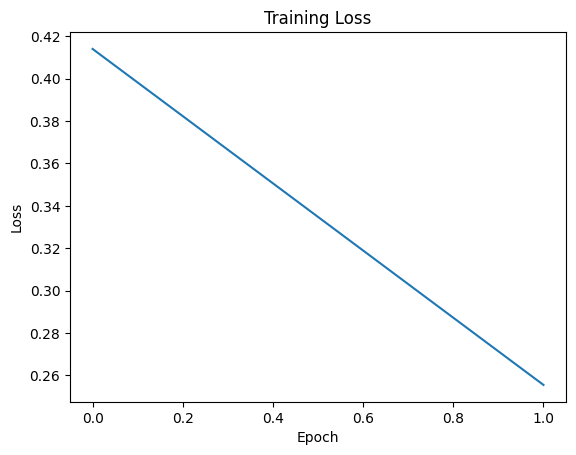

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

epochs = 2
train_losses = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

# Plot training loss
plt.plot(train_losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


# Evaluate the Model

In [16]:
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=classes))

              precision    recall  f1-score   support

      NORMAL       0.93      0.44      0.60       234
   PNEUMONIA       0.74      0.98      0.85       390

    accuracy                           0.78       624
   macro avg       0.84      0.71      0.72       624
weighted avg       0.81      0.78      0.75       624



# Confusion Matrix

In [18]:
import os

# Pastikan folder docs ada
os.makedirs("docs", exist_ok=True)

# Baru simpan
plt.savefig("docs/confusion_matrix.png")


<Figure size 640x480 with 0 Axes>

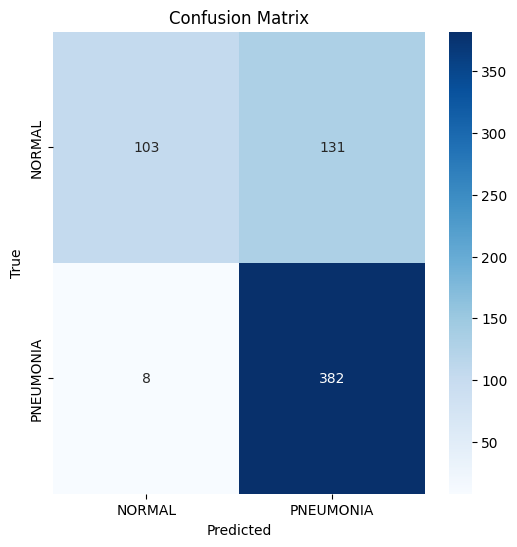

In [19]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig("docs/confusion_matrix.png")
plt.show()


# 9. Sample Prediction Visualization

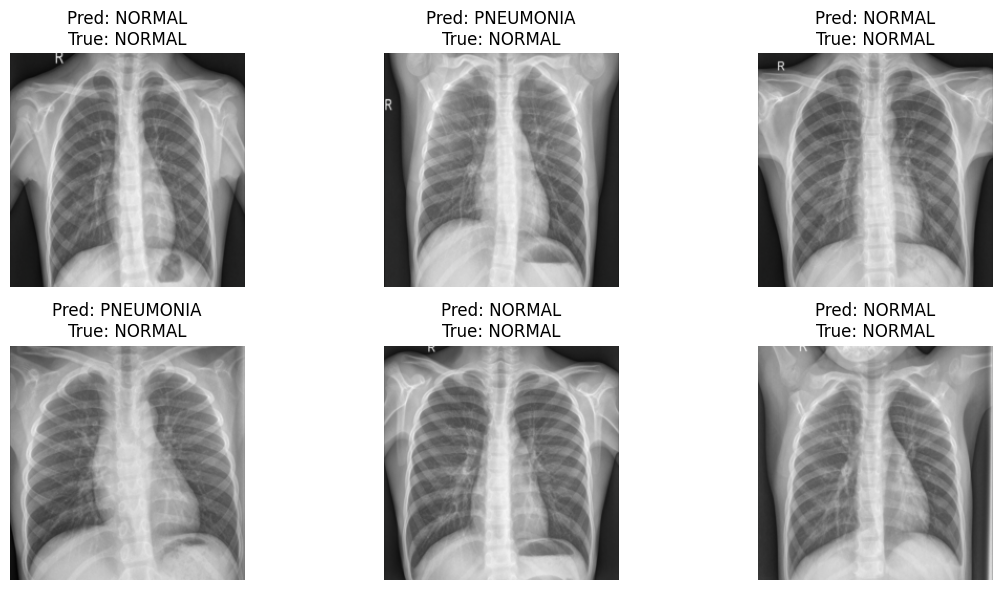

In [20]:
def show_sample_predictions(model, loader, n=6):
    model.eval()
    images, labels = next(iter(loader))
    images = images[:n]
    labels = labels[:n]
    outputs = model(images.to(device))
    _, preds = torch.max(outputs, 1)

    plt.figure(figsize=(12, 6))
    for i in range(n):
        ax = plt.subplot(2, 3, i + 1)
        img = images[i].permute(1, 2, 0).numpy()
        img = (img * np.array([0.229, 0.224, 0.225]) +
               np.array([0.485, 0.456, 0.406]))
        img = np.clip(img, 0, 1)
        plt.imshow(img)
        plt.title(f"Pred: {classes[preds[i]]}\nTrue: {classes[labels[i]]}")
        plt.axis("off")
    plt.tight_layout()
    plt.savefig("docs/sample_predictions.png")
    plt.show()

show_sample_predictions(model, test_loader)


# Save Model & Push ke GitHub

In [21]:
torch.save(model.state_dict(), "medical_xray_resnet18.pth")
